# Music Genre Classsification

We did model training using following models and checked the accuracy.
- XGBoost
- SVM
- Random Forest
- KNN
- DNN
- CNN
- LSTM

- In this file, we will compare the accuracy of the models.
- And then we will see how well the best model (LSTM) works on test files

### Importing required packages

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns 
from collections import Counter
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import librosa
import os
from pathlib import Path

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Comparing different models

In [4]:
accuracy = {
    'XG Boost' : 81.0,
    'SVM' : 80.5,
    'Random Forest' : 79.0,
    'KNN' : 77.0,
    'DNN' : 80.0,
    'CNN' : 80.8,
    'LSTM' : 86.0
}
accuracy_models_list = []
for model in accuracy:
    accuracy_models_list.append([model, accuracy[model]])
accuracy_df = pd.DataFrame(accuracy_models_list, columns=['Model Name', 'Accuracy']).sort_values(by='Accuracy', ascending=False, ignore_index=True)
accuracy_df

,Model Name,Accuracy
0,LSTM,86.0
1,XG Boost,81.0
2,CNN,80.8
3,SVM,80.5
4,DNN,80.0
5,Random Forest,79.0
6,KNN,77.0


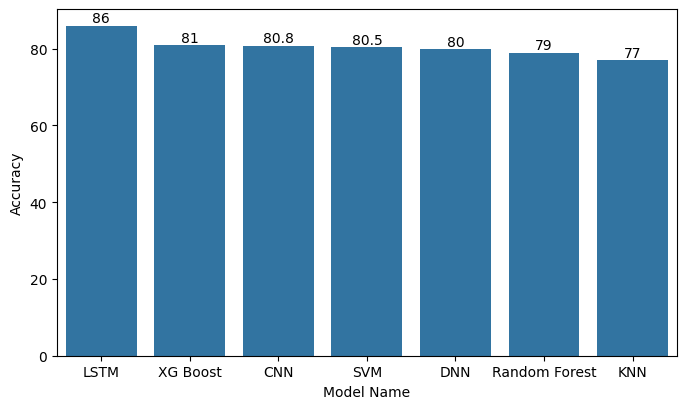

In [17]:
plt.figure(figsize = (8, 4.5))
ax = sns.barplot(accuracy_df, x='Model Name', y='Accuracy')
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

### Loading LSTM model from pt file

In [23]:
class LSTM_music(nn.Module):
    def __init__(self):
        super(LSTM_music, self).__init__()
        self.lstm1 = nn.LSTM(input_size=20, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    
    def forward(self,x):
        out, _ = self.lstm1(x)
        out = self.lstm2(out)[0]
        out = self.lstm3(out)[0][:, -1, :]
        out = self.fc(out)
        return out

model = LSTM_music()
model.load_state_dict(torch.load('LSTM_best_model.pt', map_location=device))
model.eval()
model.to(device)

LSTM_music(
  (lstm1): LSTM(20, 128, batch_first=True)
  (lstm2): LSTM(128, 256, batch_first=True)
  (lstm3): LSTM(256, 256, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [43]:
mapping = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
value_to_label = {value : label for label, value in mapping.items()}
value_to_label

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

### Loading mean and std values

In [64]:
loaded = np.load('mean_std.npz')
mean = loaded['mean']
std = loaded['std']

Padding function

In [26]:
def padding(array, desired_size):
    curr_size = array.shape[0]
    padding_required = desired_size - curr_size
    return np.pad(array, (0, padding_required), mode = 'symmetric') 

### Predict Function

In [121]:
frame_length = 1024 
hop_length = 512
def predict_genre(file_path):
    signal, sr = librosa.load(file_path)
    signal_array = []
    num = round(len(signal)/(3*sr))
    for i in range(num - 1):
        signal_array.append(signal[3*i*sr : 3*(i+1)*sr])
    if (len(signal) < 3*num*sr):
        print(f'file path = {file_path}, number of 3s files = {num}')
        signal_array.append(padding(signal[3*(num-1)*sr :], 3*sr))
    else:
        signal_array.append(signal[3*(num-1)*sr : 3*num*sr])
    mfcc_array = []
    for i in range(num):
        mfcc_array.append(np.array(librosa.feature.mfcc(y=signal_array[i], sr=sr, n_mfcc=20, n_fft=frame_length, hop_length=hop_length)))
    mfcc_array = np.array(mfcc_array)
    mfcc_array = ((mfcc_array - mean) / std)
    actual_label = file_path.split('\\')[-1].split('.')[0]
    prediction_array = []
    for i in range(num):
        value = torch.argmax(model(torch.tensor(mfcc_array[i].T).unsqueeze(0)))
        prediction_array.append(value_to_label[value.item()])
    count_predictions = Counter(prediction_array)
    print(f'Actual genre = {actual_label}')
    predicted_genre = count_predictions.most_common(1)[0][0]
    print(f'Predicted Genre = {predicted_genre}')
    print('Probabilites for Prediction:')
    for genre in count_predictions:
        print(f'{genre} : {(count_predictions[genre]/num):.2f}')
    return predicted_genre    

### Making Prediction for 10 random files

In [127]:
root_folder = 'data/to_predict'
i = 1
for root, dirs, files in os.walk(root_folder):
    for file in files:
        print(f'File Number {i}:')
        i += 1
        file_path = Path(os.path.join(root_folder, file))
        genre = predict_genre(str(file_path))
        print('-'*30)

File Number 1:
Actual genre = blues
Predicted Genre = blues
Probabilites for Prediction:
blues : 0.80
disco : 0.20
------------------------------
File Number 2:
Actual genre = classical
Predicted Genre = classical
Probabilites for Prediction:
classical : 1.00
------------------------------
File Number 3:
Actual genre = country
Predicted Genre = country
Probabilites for Prediction:
country : 0.90
pop : 0.10
------------------------------
File Number 4:
Actual genre = disco
Predicted Genre = disco
Probabilites for Prediction:
disco : 1.00
------------------------------
File Number 5:
Actual genre = hiphop
Predicted Genre = hiphop
Probabilites for Prediction:
hiphop : 1.00
------------------------------
File Number 6:
Actual genre = jazz
Predicted Genre = jazz
Probabilites for Prediction:
jazz : 1.00
------------------------------
File Number 7:
Actual genre = metal
Predicted Genre = metal
Probabilites for Prediction:
metal : 1.00
------------------------------
File Number 8:
Actual genre